In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.rcParams.update({
    # "font.size": 16,           # Increase default font size
    # "axes.titlesize": 18,      # Title font size
    "axes.labelsize": 14,      # Axis label font size
    "xtick.labelsize": 14,     # X tick label font size
    "ytick.labelsize": 14,     # Y tick label font size
    # "legend.fontsize": 14      # Legend font size
})
import pandas as pd
import pickle
from pathlib import Path
import os, sys, glob

In [10]:
def load_one_pickle(file_path):
    try:
        with open(file_path, "rb") as f:
            return pickle.load(f)
    except EOFError:
        print(f"Skipping corrupted file: {file_path}")
        return None
import joblib 

def load_data(folder_path, n_jobs=-1):
    file_paths = glob.glob(os.path.join(folder_path, "*.pkl"))
    records = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(load_one_pickle)(fp) for fp in file_paths
    )
    # Remove None entries (corrupted files)
    records = [r for r in records if r is not None]
    df = pd.DataFrame(records)
    df.sort_values("date", ascending=False, inplace=True, ignore_index=True)
    return df

In [11]:
folder_path = Path("../output/", n_jobs=4)
main_dataframe = load_data(folder_path)
# post_process(main_dataframe)

/tmp/ipykernel_496063/3744007170.py:1: DeprecationWarning: support for supplying keyword arguments to pathlib.PurePath is deprecated and scheduled for removal in Python 3.14
  folder_path = Path("../output/", n_jobs=4)


In [12]:
main_dataframe.head(5)

,total_time,solver,patch_size,patch_size_max,memory_usage,n_quadratures_local,n_quadratures_global,n_processes,mesh_size,compiled,date,output_file,compilation_time
0,48.840678,CLARABEL,2397,True,14.257500,2397,38391,16,0.010,True,2025-10-25_15-51-20,./output/output_-CLARABEL_-2397_-16_0.01_True.pkl,762.975308
1,14.857912,CLARABEL,384,True,13.038326,384,6231,16,0.025,True,2025-10-25_15-36-44,./output/output_-CLARABEL_-384_-16_0.025_True.pkl,57.759497
2,6.281211,CLARABEL,72,True,12.770153,72,1164,16,0.060,True,2025-10-25_15-35-23,./output/output_-CLARABEL_-72_-16_0.06_True.pkl,37.186678
3,3.903942,CLARABEL,3,True,12.854130,3,51,16,0.300,True,2025-10-25_15-34-31,./output/output_-CLARABEL_-3_-16_0.3_True.pkl,36.975960
4,2.400892,CLARABEL,15,True,2.352791,15,51,3,0.300,True,2025-10-25_15-28-43,./output/output_-CLARABEL_-15_-3_0.3_True.pkl,30.739638


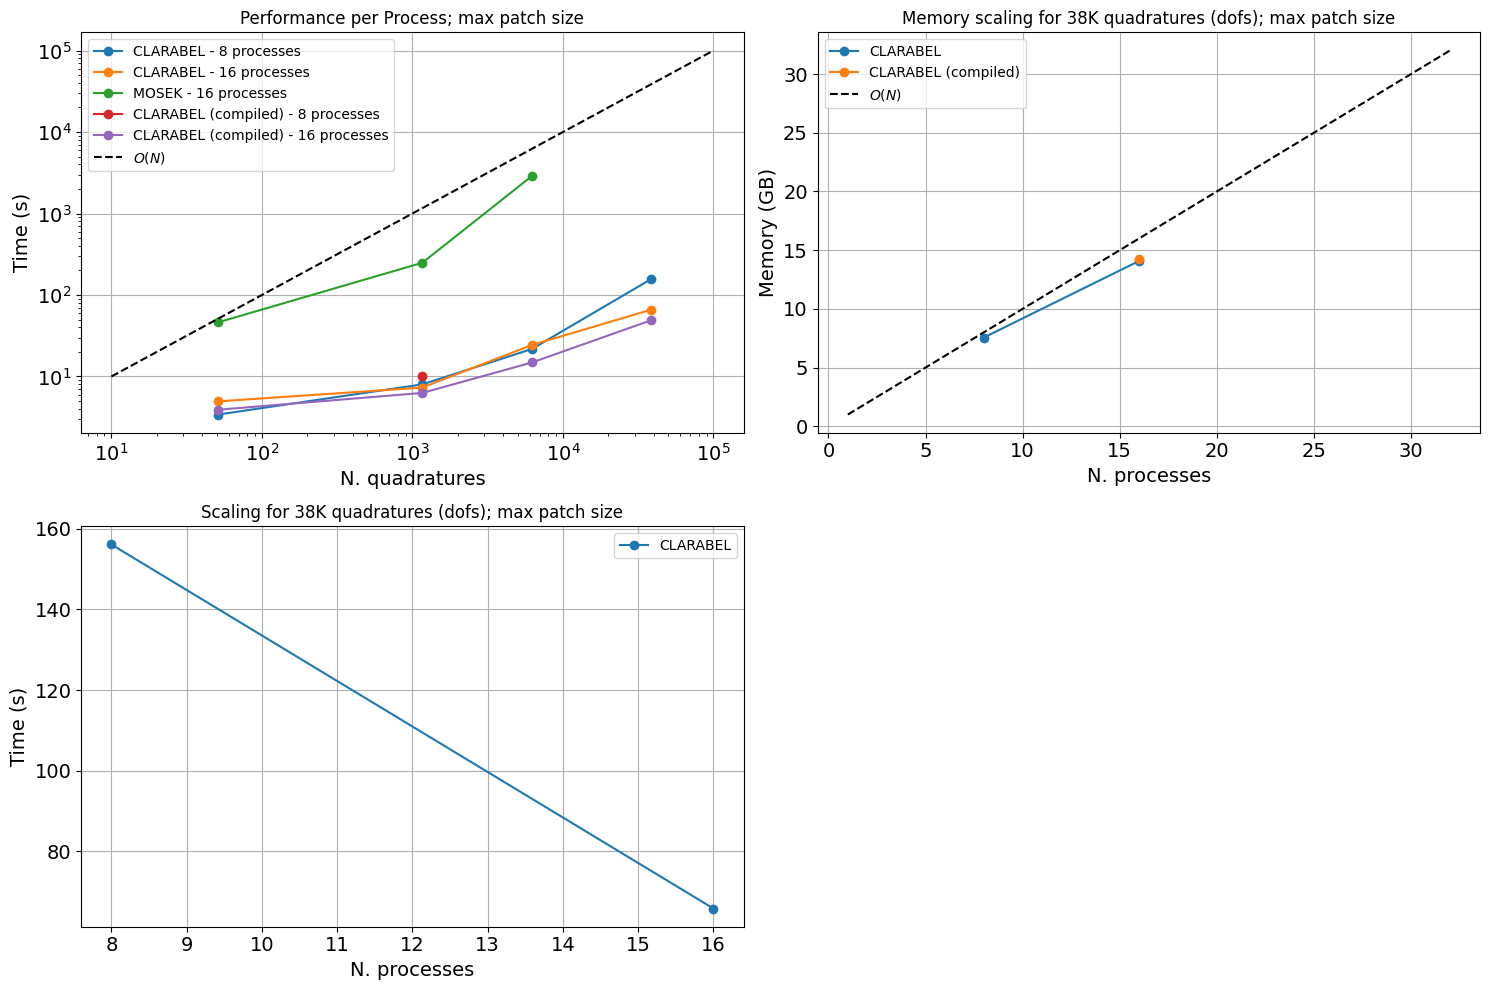

In [13]:
def plot_performance_per_process(main_dataframe, solvers, n_processes, ax):
    for solver in solvers:
        df_filter = (
            (main_dataframe["patch_size_max"] == True) &
            (main_dataframe["solver"] == solver) & 
            (main_dataframe["compiled"] == False)
        )
        df_local = main_dataframe[df_filter]
        if not df_local.empty:
            for n in n_processes:
                df_n = df_local[df_local["n_processes"] == n]
                if not df_n.empty:
                    ax.plot(df_n["n_quadratures_global"], df_n["total_time"], 'o-', label=f"{solver} - {n} processes")
    
    for solver in solvers:
        df_filter = (
            (main_dataframe["patch_size_max"] == True) &
            (main_dataframe["solver"] == solver) & 
            (main_dataframe["compiled"] == True)
        )
        df_local = main_dataframe[df_filter]
        if not df_local.empty:
            for n in n_processes:
                df_n = df_local[df_local["n_processes"] == n]
                if not df_n.empty:
                    ax.plot(df_n["n_quadratures_global"], df_n["total_time"], 'o-', label=f"{solver} (compiled) - {n} processes")
                
    n = np.linspace(10, 1e5, 10)
    ax.plot(n, n, 'k--', label="$O(N)$")

    ax.set_xlabel("N. quadratures")
    ax.set_ylabel("Time (s)")
    ax.legend()
    ax.set_title("Performance per Process; max patch size")
    ax.grid()
    ax.set_xscale("log")
    ax.set_yscale("log")

def plot_memory_per_process(main_dataframe, solvers, mesh_size, ax):
    for solver in solvers:
        df_filter = (
            (main_dataframe["patch_size_max"] == True) &
            (main_dataframe["solver"] == solver) & 
            (main_dataframe["mesh_size"] == mesh_size) &  
            (main_dataframe["compiled"] == False)
        )
        df_local = main_dataframe[df_filter]
        if not df_local.empty:
            ax.plot(df_local["n_processes"], df_local["memory_usage"], 'o-', label=f"{solver}")

            n_dofs = df_local["n_quadratures_global"].iloc[0]
            ax.set_title(f"Memory scaling for {n_dofs//1000}K quadratures (dofs); max patch size")
                
    for solver in solvers:
        df_filter = (
            (main_dataframe["patch_size_max"] == True) &
            (main_dataframe["solver"] == solver) & 
            (main_dataframe["mesh_size"] == mesh_size) &  
            (main_dataframe["compiled"] == True)
        )
        df_local = main_dataframe[df_filter]
        if not df_local.empty:
            ax.plot(df_local["n_processes"], df_local["memory_usage"], 'o-', label=f"{solver} (compiled)")

    n = np.linspace(1, 32, 10)
    ax.plot(n, n, 'k--', label="$O(N)$")

    ax.set_xlabel("N. processes")
    ax.set_ylabel("Memory (GB)")
    ax.legend()
    ax.grid()
    # ax.set_xscale("log")
    # ax.set_yscale("log")


def plot_scaling(main_dataframe, solvers, mesh_size, ax):
    for solver in solvers:
        df_filter = (
            (main_dataframe["patch_size_max"] == True) &
            (main_dataframe["solver"] == solver) & 
            (main_dataframe["mesh_size"] == mesh_size) &
            (main_dataframe["compiled"] == False)
        )
        df_local = main_dataframe[df_filter]
        if not df_local.empty:
            ax.plot(df_local["n_processes"], df_local["total_time"], 'o-', label=f"{solver}")

            n_dofs = df_local["n_quadratures_global"].iloc[0]
            ax.set_title(f"Scaling for {n_dofs//1000}K quadratures (dofs); max patch size")

    # n = np.linspace(1, 16, 10)
    # ax.plot(n, 1/n, 'k--', label="$O(N^{-1})$")

    ax.set_xlabel("N. processes")
    ax.set_ylabel("Time (s)")
    ax.legend()
    ax.grid()
    # ax.set_xscale("log")
    # ax.set_yscale("log")

ncols = 2
nrows = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 + 5*ncols, 5*nrows))

solvers = ["CLARABEL", "MOSEK"]
n_processes = [1, 4, 8, 16]
plot_performance_per_process(main_dataframe, solvers, n_processes, ax[0,0])
plot_memory_per_process(main_dataframe, solvers, mesh_size=0.01, ax=ax[0,1])
plot_scaling(main_dataframe, solvers, mesh_size=0.01, ax=ax[1,0])
fig.delaxes(ax[1,1])  # Remove unused subplot
fig.tight_layout()